<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
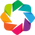

ImportError: cannot import name 'cams_product' from 'grs' (/home/harmel/Dropbox/Dropbox/work/git/satellite_app/grs/grs/__init__.py)

In [1]:
'''
Main program
'''
from pathlib import Path
import os, shutil
import zipfile
import tarfile
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt


import numpy as np
import xarray as xr
import logging

import memory_profiler
%load_ext memory_profiler

from s2driver import driver_S2_SAFE as S2

from grs import product, acutils,cams_product, l2a_product,__version__
from grs.fortran.grs import main_algo as grs_solver

opj = os.path.join
__version__

In [ ]:
file = '/data/satellite/Sentinel-2/L1C/20PNC/2023/03/17/S2B_MSIL1C_20230317T144729_N0509_R139_T20PNC_20230317T175159.SAFE/'


cams_file = '/data/satellite/S2/cnes/CAMS/2022-07-31-cams-global-atmospheric-composition-forecasts.nc'
file_nc = file.replace('.SAFE', '.nc')


bandIds = range(13)
resolution = 20
#l1c = S2.sentinel2_driver(file, band_idx=bandIds, resolution=resolution)
#print(l1c.crs)
#l1c.load_product()

In [ ]:
if not os.path.exists(file_nc):
    l1c = S2.sentinel2_driver(file, band_idx=bandIds, resolution=resolution)
    print(l1c.crs)
    l1c.load_product()
    prod = product(l1c.prod)
    encoding = {'bands': {'dtype': 'int16', 'scale_factor': 0.00005, 'add_offset': .3, '_FillValue': -32768},
                'vza': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999},
                'raa': {'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -9999},
                'sza': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999}}
    l1c.prod.to_netcdf(file_nc, encoding=encoding)
    l1c.prod.close()

else:
    prod = product(xr.open_dataset(file_nc))
prod.raster

In [ ]:

prod.raster.bands
     

In [ ]:
import grstbx
from grstbx import visual
v=visual.view_spectral(prod.raster.bands,reproject=True)

In [ ]:
v.minmax=[0,0.5]
v.visu()

In [ ]:
geom_ = v.get_geom(v.aoi_stream,crs=prod.raster.rio.crs)

raster_clipped = xr.Dataset()
prod.raster.bands.rio.clip(geom_.geometry.values)
for param in prod.raster.keys():
    da = prod.raster[param]
    if 'x' in da.dims and 'y' in da.dims:
        raster_clipped[param]=da.rio.clip(geom_.geometry.values)
    else:
        raster_clipped[param]=da
raster_clipped.attrs = prod.raster.attrs

In [ ]:
raster_clipped

In [ ]:

#%matplotlib ipympl
import cartopy.crs as ccrs
str_epsg = str(raster_clipped.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

plt.figure(figsize=(15,15))
raster_clipped.bands.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

In [ ]:
raster_clipped.raa.sel(wl=slice(400,1700)).plot.imshow(col='wl',col_wrap=4,robust=True,cmap=plt.cm.Spectral_r)

In [ ]:

##################################
# GET ANCILLARY DATA (Pressure, O3, water vapor, NO2...
##################################

cams = cams_product(raster_clipped, cams_file=cams_file)
cams.plot_params()

In [ ]:
wind = np.sqrt(cams.raster['v10']**2+cams.raster['u10']**2)

In [ ]:

##################################
## ADD ELEVATION AND PRESSURE BAND
##################################
#prod.get_elevation()


#####################################
# LOAD LUT FOR ATMOSPHERIC CORRECTION
#####################################
#logging.info('loading lut...' + prod.lutfine)

lut_file = '/data/vrtc/xlut/toa_lut_opac_wind_up.nc'
aero_lut = xr.open_dataset(lut_file)
aero_lut['wl']=aero_lut['wl']*1000
aero_lut

#lutf = acutils.lut(prod.band_names)
#lutc = acutils.lut(prod.band_names)
#lutf.load_lut(prod.lutfine, prod.sensordata.indband)
#lutc.load_lut(prod.lutcoarse, prod.sensordata.indband)


In [ ]:
####################################
#    absorbing gases correction
####################################
gas_trans = acutils.gaseous_transmittance(prod, cams)
Tg_raster = gas_trans.get_gaseous_transmittance()

logging.info('correct for gaseous absorption')
for wl in prod.wl.values:
    raster_clipped['bands'].loc[wl] = raster_clipped.bands.sel(wl=wl) / Tg_raster.sel(wl=wl).interp(x=prod.raster.x,
                                                                                              y=prod.raster.y)
raster_clipped.bands.attrs['gas_absorption_correction'] = True

In [ ]:
#plt.figure()
#Tg_raster.mean('x').mean('y').plot()
fig,axs = plt.subplots(4,4,figsize=(15,9),sharey=True,sharex=True)
axs=axs.ravel()
for iwl in range(13):
    Tg_raster.isel(wl=iwl).plot(ax=axs[iwl])
    axs[iwl].set_title( str(Tg_raster.isel(wl=iwl).wl.values))
#p = Tg_raster.plot.imshow(col='wl', col_wrap=3, robust=True, cmap=plt.cm.Spectral_r,
#                          subplot_kws=dict(xlabel='', ylabel='', xticks=[], yticks=[]))

In [ ]:
import hgrs
cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                     "grey",   'forestgreen','yellowgreen',
                                                     "khaki", "gold",
                                                     'orangered', "firebrick", 'purple'])

norm = mpl.colors.Normalize(vmin=0.001,vmax=1.1)#-3, vmax=np.log10(1.5))

def transmittance_dir(aot,M,rot=0):    
    return np.exp(-(rot+aot)*M)
azi_=90
sza_=28
vza_=3
auxdata = hgrs.auxdata()#wl=masked.wl)
wl = raster_clipped.drop_sel(wl=1375).wl_true
sunglint_eps = auxdata.sunglint_eps['mean'].interp(wl=wl)
sunglint_corr = sunglint_eps / sunglint_eps.sel(wl=2200,method='nearest')
rot = auxdata.rot.interp(wl=wl)
aero_lut_=aero_lut.sel(wind=2)#,wl=slice(800,2500))#.sel(vza=vza_,sza=sza_,azi=azi_,method='nearest')

M=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))

In [ ]:
rot

In [ ]:
prod.sensordata.rg

In [ ]:

######################################
# Water mask
######################################
# Compute NDWI

#green = raster_clipped.bands.sel(wl=565,method='nearest')
#nir = raster_clipped.bands.sel(wl=prod.b865)

green = raster_clipped.bands.sel(wl=490,method='nearest')
nir = raster_clipped.bands.sel(wl=842,method='nearest')#prod.b865)
swir = raster_clipped.bands.sel(wl=prod.b1600)
b2200 = raster_clipped.bands.sel(wl=prod.b2200)

ndwi = (green - nir) / (green + nir)
ndwi_swir = (green - swir) / (green + swir)

raster_clipped['ndwi'] = ndwi
raster_clipped.ndwi.attrs = {
'description': 'Normalized difference spectral index between bands at ' + str(prod.b565) + ' and ' + str(
    prod.b865) + ' nm', 'units': '-'}
raster_clipped['ndwi_swir'] = ndwi_swir
raster_clipped.ndwi_swir.attrs = {
'description': 'Normalized difference spectral index between bands at ' + str(prod.b565) + ' and ' + str(
    prod.b1600) + ' nm', 'units': '-'}



  
                                               


In [ ]:
plt.figure()
(np.cos(np.radians(raster_clipped.vza.isel(wl=1))/np.cos(np.radians(raster_clipped.vza.isel(wl=5))))).plot.imshow(vmin=0.96)

In [ ]:
plt.close('all')
plt.figure()
(raster_clipped.raa.isel(wl=-1)-raster_clipped.raa.isel(wl=-2)).plot.imshow(robust=True)

In [ ]:

def mu_N(sza,vza,azi):
    '''
    self.azi: azimuth in rad for convention azi=180 when sun-sensenor in oppositioon
    :return: scattering angle in rad
    '''
    vzar=np.radians(vza)
    azir=np.radians(azi)
    szar=np.radians(sza)
    cos_alpha = np.cos(szar) * np.cos(vzar) + np.sin(szar) * np.sin(vzar) * np.cos(azir)
    
    return (np.cos(szar) + np.cos(vzar)) / np.sqrt(2*(1+cos_alpha))
    # ang = np.cos(np.pi - sza) * np.cos(vza) - np.sin(np.pi - sza) * np.sin(vza) * np.cos(azi)
    #ang = np.arccos(ang)
    #return np.degrees(ang)

def p_slope(sza,vza,azi,sigma2=0.02):
    cosN = mu_N(sza,vza,azi)
    thetaN=np.arccos(cosN)
    #stats == 'cm_iso':
    #TODO check consitency between sigma2 and formulation
    #Pdist_ = 1. / (np.pi *2.* sigma2) * np.exp(-1./2 * np.tan(thetaN) ** 2 / sigma2)
    return 1. / (np.pi * sigma2) * np.exp(- np.tan(thetaN) ** 2 / sigma2)/cosN**4


In [ ]:
raster_clipped['mu_N']=np.degrees(np.arccos(mu_N(raster_clipped.sza,raster_clipped.vza,raster_clipped.raa)))
raster_clipped['p_slope']=p_slope(raster_clipped.sza,raster_clipped.vza,raster_clipped.raa,sigma2=0.03)

In [ ]:
param='p_slope'
param='mu_N'
raster_clipped['sunglint_dir']=(raster_clipped[param])/raster_clipped[param].isel(wl=-1)
raster_clipped['sunglint_dir'].sel(wl=slice(400,1700)).plot.imshow(col='wl',col_wrap=4,robust=True,cmap=plt.cm.Spectral_r)#,vmax=12)
#sunglint_dir=xr.DataArray([1,0.7,0.8,0.85,0.85,0.9,0.9,0.7,1,1,0.85,1],coords={'wl':coarse_raster.wl})

In [ ]:
param='p_slope'
#param='raa'
raster_clipped['sunglint_dir']=(raster_clipped[param])/raster_clipped[param].isel(wl=-1)
raster_clipped['sunglint_dir'].sel(wl=slice(400,1700)).plot.imshow(col='wl',col_wrap=4,robust=True,cmap=plt.cm.Spectral_r)#,vmax=12)
#sunglint_dir=xr.DataArray([1,0.7,0.8,0.85,0.85,0.9,0.9,0.7,1,1,0.85,1],coords={'wl':coarse_raster.wl})

In [ ]:
#%matplotlib ipympl
import cartopy.crs as ccrs
str_epsg = str(raster_clipped.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)
fig = plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1, projection=proj)
ndwi.plot.imshow(robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})#,vmin=-0.3,vmax=0.3,cmap=plt.cm.RdBu_r)  
ax = plt.subplot(1, 2, 2, projection=proj)
ndwi_swir.plot.imshow(robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35}) 


In [ ]:
prod.green_swir_index_threshold

In [ ]:
plt.figure(figsize=(15,15))
masked = raster_clipped.bands.where((ndwi > -0.0) &
                                               (ndwi_swir > 0) &
                                               (b2200 < 0.2))
raster_clipped[param].sel(wl=560).plot.imshow(cmap=plt.cm.Spectral_r, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
masked.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

raster_clipped['bands']=masked

In [ ]:
plt.figure(figsize=(15,15))
((wind+0.586)/195.3).plot.imshow( cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
raster_clipped.bands.sel(wl=2190).plot.imshow(cmap=plt.cm.gray,alpha=0.43, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})


In [ ]:
plt.figure(figsize=(15,15))
raster_clipped[param].sel(wl=2190).plot.imshow(cmap=plt.cm.Spectral_r, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})
raster_clipped.bands.sel(wl=2190).plot.imshow(cmap=plt.cm.gray, robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})


In [ ]:
plt.figure(figsize=(15,15))
raster_clipped[param].sel(wl=1600,method='nearest').plot.imshow(robust=True,subplot_kws=dict(projection=proj),cmap=plt.cm.Spectral_r,cbar_kwargs={'shrink':0.35})
raster_clipped.bands.sel(wl=1600,method='nearest').plot.imshow(robust=True,subplot_kws=dict(projection=proj),cmap=plt.cm.gray,cbar_kwargs={'shrink':0.35})

In [ ]:
plt.figure(figsize=(15,15))
wl1,wl2=842,865
geom_ratio = sunglint_eps.sel(wl=wl1,method='nearest')*raster_clipped[param].sel(wl=wl1,method='nearest')/(sunglint_eps.sel(wl=wl2,method='nearest')*raster_clipped[param].sel(wl=wl2,method='nearest'))
band_ratio = raster_clipped.bands.sel(wl=wl1)/raster_clipped.bands.sel(wl=wl2)
vmin,vmax=0.75,1.25
geom_ratio.plot.imshow(robust=True,cmap=plt.cm.Spectral_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35},vmin=vmin,vmax=vmax)
band_ratio.plot.imshow(robust=True,cmap=plt.cm.Spectral_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35},vmin=vmin,vmax=vmax)


In [ ]:
plt.figure(figsize=(15,15))
(band_ratio/geom_ratio).plot.imshow(robust=True,cmap=plt.cm.RdBu_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})#,vmin=0.9,vmax=1.4)

In [ ]:
sunglint_eps#.interp(wl=wl2)

In [ ]:
plt.figure(figsize=(15,15))
wl1,wl2=1600,2200
geom_ratio = sunglint_eps.sel(wl=wl1,method='nearest')*raster_clipped[param].sel(wl=wl1,method='nearest')/( sunglint_eps.sel(wl=wl2,method='nearest')*raster_clipped[param].sel(wl=wl2,method='nearest'))
band_ratio = raster_clipped.bands.sel(wl=wl1,method='nearest')/raster_clipped.bands.sel(wl=wl2,method='nearest')
vmin,vmax=0.9,1.3
geom_ratio.plot.imshow(robust=True,cmap=plt.cm.Spectral_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35},vmin=vmin,vmax=vmax)
band_ratio.plot.imshow(robust=True,cmap=plt.cm.Spectral_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35},vmin=vmin,vmax=vmax)


In [ ]:
plt.figure(figsize=(15,15))
(band_ratio/geom_ratio).plot.imshow(robust=True,cmap=plt.cm.RdBu_r,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})#,vmin=0.9,vmax=1.4)

In [ ]:
raster_clipped

In [ ]:
xcoarsen,ycoarsen=20,20
minpix_percent = 0.8
threshold = minpix_percent*xcoarsen*ycoarsen
subset=raster_clipped.drop_sel(wl=[945,1375]).coarsen(x=xcoarsen, y=ycoarsen, boundary="trim").mean()
count = raster_clipped.bands.sel(wl=565,method='nearest').coarsen(x=xcoarsen, y=ycoarsen, boundary="trim").count()
#coarse_raster['water_pixel_number']=raster_clipped.bands.sel(wl=560).drop('wl').coarsen(x=xcoarsen, y=ycoarsen).count().bands.sel(wl=[865,1600,2200],method='nearest')

In [ ]:
attrs = subset.attrs
for param in subset.keys():
    da = subset[param]
    if 'x' in da.dims and 'y' in da.dims:
        subset[param]=da.where(count>threshold)
    else:
        subset[param]=da
subset.attrs = attrs

In [ ]:
plt.figure()
subset.bands.sel(wl=[670,565,490],method='nearest').plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))
plt.show()

In [ ]:
v=visual.view_spectral(subset.bands,reproject=True)
v.minmax=[0,0.5]
v.visu()

In [ ]:
subset

In [ ]:
wl_full = subset.wl_true


In [ ]:
subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=0.03)
subset.p_slope.plot(col='wl',cmap=plt.cm.Spectral_r)

In [ ]:
subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=0.02)
subset.p_slope.plot(col='wl',cmap=plt.cm.Spectral_r)#,col_wrap=6

In [ ]:
subset.bands.plot(col='wl',cmap=plt.cm.Spectral_r,vmin=0)#,col_wrap=6

In [ ]:
subset

In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import NonlinearConstraint

#nonlinear_constraint = NonlinearConstraint(cons_f, 0, 0.1)


def transmittance_dir(aot,air_mass,rot=0):    
    return np.exp(-(rot+aot)*air_mass)

def toa_simu( aot, rot, Rtoa_lut, sunglint_eps,air_mass, aot_ref, BRDFg):
    '''
    '''
    #Rrs=R700 #0.000#1
    aot_ = aot.interp(aot_ref=aot_ref)
    Rdiff = Rtoa_lut.interp(aot_ref=aot_ref).values
    #Rdiff[0] =  Rdiff[0] +Rrs
    Tdir = transmittance_dir(aot_, air_mass, rot=rot)
    #sunglint_corr =  sunglint_eps
    Rdir = Tdir *sunglint_eps* BRDFg #/ sunglint_corr.sel(wl=2200,method='nearest')
    # sunglint_toa.Rtoa.plot(x='wl',hue='aot_ref',ax=axs[0])
    
    return Rdiff + Rdir
    
def func(x, aot, rot, Rtoa_lut, sunglint_eps,air_mass, y):
    cost = y-toa_simu(aot, rot, Rtoa_lut, sunglint_eps,air_mass, *x) 
    wg=0
    for num in cost[:-2]:
        if (num < 0):
           wg+= (num)**2
    cost = np.concatenate([cost[-2:], cost[-2:] +wg**2])
    
    regul = cost[-2]*np.array([x[0]-0.07])

    cost = np.concatenate([cost,regul])
    #print(cost.values)
    #cost_visnir=cost[:-2]
    #cost_visnir[cost_visnir>0]=0
    #return np.concatenate([cost_visnir**2,cost[-2:]])#**2
    return cost


def cons_f(x, aot, rot, Rtoa_lut, sunglint_eps, y):
    return y-toa_simu(aot, rot, Rtoa_lut, sunglint_eps, *x)  # /sigma

def errFit( hess_inv, resVariance):
    '''
    Error/uncertainty of the estimated parameters
    :param resVariance:
    :return:
    '''
    return np.sqrt(np.diag(hess_inv * resVariance))

In [ ]:
from multiprocessing import Pool  # Process pool
from multiprocessing import sharedctypes
import itertools

width,height = len(subset.x),len(subset.y)
block_size=5
window_idxs = [(i, j) for i, j in
               itertools.product(range(0, width, block_size),
                                 range(0, height, block_size))]
#window_idxs

In [ ]:
azi_=30
sza_=28
vza_=6

#subset=subset.drop_sel(wl=945)


wl_full =subset.wl_true

wl_swir = wl_full.wl #[490,565,740,783,842,865,1610, 2190]#[842,865,1610, 2190]705,740,783,
ls=['-','--']
sunglint_eps = auxdata.sunglint_eps['mean'].interp(wl=wl_full)
sunglint_eps = sunglint_eps /sunglint_eps.sel(wl=2190,method='nearest')
fig, axs = plt.subplots(1,2, figsize=(12, 5))
rot = auxdata.rot.interp(wl=wl_full)
for sigma2 in (0.01,0.015,0.025,0.04):
    for ii,imod in enumerate((0,2)):
        aero_lut_=aero_lut.sel(wind=2).isel(model=imod)
        print(aero_lut_.model.values,sigma2)
        aot = aero_lut_.aot.interp(wl=wl_full,method='quadratic')
        
        #sigma2=0.0175
        subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=sigma2)
        subset_=subset.isel(y=30,x=24)
        sza_=subset_.sza
        vza_=subset_.vza.mean('wl')
        air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
        #Rtoa_lut = aero_lut_.I.sel(sza=sza_,vza=vza_,azi=azi_,method='nearest').squeeze()/np.cos(np.radians(sza_))
        #Rtoa_lut = Rtoa_lut.interp(wl=wl_full,method='quadratic')
        azi_=180-subset_.raa
        Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
        #raa = 180 -subset_.raa.sel(wl=wl_process)
        # slice swir bands
        aot_ = aot.sel(wl=wl_swir)
        rot_ = rot.sel(wl=wl_swir)
        Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
        sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
        sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
        
        x0=[0.11, 0.0]#,0.01]
        
        y= subset_.bands
        res_lsq = least_squares(func, x0,args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                #bounds=([0.00, 0.,0.0001], [1.21, 1.3,0.1]), # f_scale=0.1,diff_step=1e-4,
                                x_scale='jac',
                                bounds=([0.00, 0.], [1.21, 0.6]),ftol=1e-2, xtol=1e-2,gtol=1e-3,
                                max_nfev=20)
        xres = res_lsq.x
        #print(res_lsq)
        resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
        hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
        
        try:
            hess_inv = np.linalg.inv(hess)
            std = errFit(hess_inv, resVariance)
        except:
            std = [np.nan, np.nan]
        
        Rsim = toa_simu( aot, rot, Rtoa_lut, sunglint_eps * sunglint_dir, air_mass,*xres)
        print(xres,std,res_lsq['cost']**0.5)   
        
        axs[0].plot(wl_full,y,color='k',marker='o',ms=2.5)
        axs[0].plot(wl_full,Rsim,color='red',ls='--')
        axs[1].plot(wl_full,(y-Rsim),marker='o',ls=ls[ii],ms=2.5) #.plot(ax=axs[1])color='k',

In [ ]:
azi_=30
sza_=28
vza_=6

#subset=subset.drop_sel(wl=945)


wl_full =subset.wl_true

wl_swir = wl_full.wl #[490,565,740,783,842,865,1610, 2190]#[842,865,1610, 2190]705,740,783,
ls=['-','--']
sunglint_eps = auxdata.sunglint_eps['mean'].interp(wl=wl_full)
sunglint_eps = sunglint_eps /sunglint_eps.sel(wl=2190,method='nearest')
fig, axs = plt.subplots(1,2, figsize=(12, 5))
rot = auxdata.rot.interp(wl=wl_full)
for sigma2 in (0.015,0.025,0.04):
    for ii,imod in enumerate((0,2)):
        aero_lut_=aero_lut.sel(wind=2).isel(model=imod)
        print(aero_lut_.model.values,sigma2)
        aot = aero_lut_.aot.interp(wl=wl_full,method='quadratic')
        
        #sigma2=0.0175
        subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=sigma2)
        subset_=subset.isel(y=15,x=12)
        sza_=subset_.sza
        vza_=subset_.vza.mean('wl')
        air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
        #Rtoa_lut = aero_lut_.I.sel(sza=sza_,vza=vza_,azi=azi_,method='nearest').squeeze()/np.cos(np.radians(sza_))
        #Rtoa_lut = Rtoa_lut.interp(wl=wl_full,method='quadratic')
        azi_=180-subset_.raa
        Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
        #raa = 180 -subset_.raa.sel(wl=wl_process)
        # slice swir bands
        aot_ = aot.sel(wl=wl_swir)
        rot_ = rot.sel(wl=wl_swir)
        Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
        sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
        sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
        
        x0=[0.11, 0.0]#,0.01]
        
        y= subset_.bands
        res_lsq = least_squares(func, x0,loss='cauchy',args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                #bounds=([0.00, 0.,0.0001], [1.21, 1.3,0.1]), #diff_step=1e-4, xtol=1e-6, ftol=1e-6,  f_scale=0.1
                                bounds=([0.00, 0.], [1.21, 0.6]),gtol=1e-2,
                                max_nfev=20)
        xres = res_lsq.x
        #print(res_lsq)
        resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
        hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
        
        try:
            hess_inv = np.linalg.inv(hess)
            std = errFit(hess_inv, resVariance)
        except:
            std = [np.nan, np.nan]
        
        Rsim = toa_simu( aot, rot, Rtoa_lut, sunglint_eps * sunglint_dir, air_mass,*xres)
        print(xres,std,res_lsq['cost']**0.5)   
        
        axs[0].plot(wl_full,y,color='k',marker='o',ms=2.5)
        axs[0].plot(wl_full,Rsim,color='red',ls='--')
        axs[1].plot(wl_full,(y-Rsim),marker='o',ls=ls[ii],ms=2.5) #.plot(ax=axs[1])color='k',

In [ ]:
sunglint_eps

In [ ]:

from multiprocessing import Pool  # Process pool
from multiprocessing import sharedctypes
import itertools

width,height = len(subset.x),len(subset.y)
width
result = np.full((width, height, 4), np.nan)

block_size=2
global chunk_process
result = np.ctypeslib.as_ctypes(np.full((width, height, 5), np.nan))
shared_array = sharedctypes.RawArray(result._type_, result)

wl_swir = [1610, 2190]
def chunk_process(args):
    window_x, window_y = args
    tmp = np.ctypeslib.as_array(shared_array)

    for ix in range(window_x, min(width, window_x + block_size)):
        for iy in range(window_y, min(height, window_y + block_size)):


            x0=[0.105, 0.0005]
            subset_ =  subset.isel(y=iy,x=ix)
            if np.isnan(subset_.bands).any():
                continue
            azi_=(180-subset_.raa)%360
            sza_=subset_.sza
            vza_=subset_.vza.mean('wl')
            air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
            Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
            Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
            y= subset_.bands
            sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
            sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
            res_lsq = least_squares(func, x0, args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                                        bounds=([0.0, 0], [1.4, 0.6]), xtol=1e-3, ftol=1e-3,gtol=1e-3,#diff_step=1e-4, 
                                                        max_nfev=20)
            xres = res_lsq.x
            resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
            hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
            
            try:
                hess_inv = np.linalg.inv(hess)
                std = errFit(hess_inv, resVariance)
            except:
                std = [np.nan, np.nan]
            tmp[ix, iy, :] = [*xres, *std,res_lsq['cost']**2]

window_idxs = [(i, j) for i, j in
               itertools.product(range(0, width, block_size),
                                 range(0, height, block_size))]

p = Pool()
res = p.map(chunk_process, window_idxs)
result = np.ctypeslib.as_array(shared_array)  

aero_img = xr.Dataset(dict(aot_ref=(["y", "x"], result[:, :, 0].T),
                                brdfg=(["y", "x"], result[:, :, 1].T),
                                aot_ref_std=(["y", "x"], result[:, :, 2].T),
                                brdfg_std=(["y", "x"], result[:, :, 3].T),
                                cost_func=(["y", "x"], result[:, :, 4].T)
                                ),
                           coords=dict(
                               x=subset.x,
                               y=subset.y),
                           attrs=dict(
                               description="aerosol and sunglint retrieval from coarse resolution data",
                               aerosol_model=Rtoa_lut_.model)
                           )

In [ ]:

fig = plt.figure(figsize=(25, 10))

for ii, param in enumerate(aero_img.keys()):
    ax = plt.subplot(3, 2, ii+1, projection=proj)
    aero_img[param].plot(ax=ax,cmap=plt.cm.Spectral_r,cbar_kwargs={'shrink':0.35})


In [ ]:
from scipy import ndimage
from numba import jit
@jit(nopython=True)
def filter2d(image, weight, windows):
    '''
     Function to convolve parameter image with uncertainty image
    :param image: parameter image
    :param weight: uncertainty image
    :param windows: size of the window for convolution
    :return: convolved result with same shape as image

    '''
    M, N = np.shape(image)
    Mf, Nf = windows
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    threshold = 0
    result = image
    for i in range(M):
        for j in range(N):
            num = 0.0
            norm = 0.0
            if weight[i, j] > threshold:
                for ii in range(Mf):
                    ix = i - Mf2 + ii
                    if ix < M:
                        for jj in range(Nf):

                            iy = j - Nf2 + jj
                            if iy < N:
                                wgt = weight[ix, iy]
                                if wgt > 0.:
                                    num += (wgt * image[ix, iy])
                                    norm += wgt
                result[i, j] = num / norm
    return result
    
def conv_mapping(x):
    """
    Nan-mean convolution
    """
    # get index of central pixel
    idx = len(x) // 2
    if np.isnan(x[idx]) and not np.isnan(np.delete(x, idx)).all():
        return np.nanmean(np.delete(x, idx))
    elif np.isnan(np.delete(x, idx)).all():
        return x[idx]
    else:
        return np.nanmean(x)

In [ ]:
(aero_img['cost_func'].mean()/ aero_img['cost_func']).plot(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

In [ ]:
windows=np.array([15, 15])
mask=np.ones((15,15))

weights = (aero_img['cost_func'].mean() / aero_img['cost_func']).values
param = aero_img['aot_ref'].values
aot_ref_smoothed = param #filter2d(param, weights, windows)
#aot_ref_smoothed

In [ ]:
# basic filter for outliers
aot_med = np.nanmedian(aot_ref_smoothed)
aot_ref_smoothed[aot_ref_smoothed>np.max([1.5*aot_med,0.05])]=aot_med

res = ndimage.generic_filter(aot_ref_smoothed, function=conv_mapping, footprint=mask, mode='nearest')

aero_img['aot_ref_smoothed'] = xr.DataArray(res, coords=dict(y=aero_img.y, x=aero_img.x))

In [ ]:
aero_img['aot_ref_smoothed'].plot(cmap=plt.cm.Spectral_r,subplot_kws=dict(projection=proj))

In [ ]:
xnew,ynew=raster_clipped.x.values,raster_clipped.y.values
aero_full = aero_img['aot_ref_smoothed'].interp(x=xnew,y=ynew,method='linear', kwargs={"fill_value": "extrapolate"})

In [ ]:
fig = plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1, projection=proj)
raster_clipped.bands.isel(wl=[3,2,1]).plot.imshow(ax=ax,rgb='wl',robust=True)#,subplot_kws=dict(projection=proj))#,cbar_kwargs={'shrink':0.35})#,vmin=-0.3,vmax=0.3,cmap=plt.cm.RdBu_r)  
#ax = plt.subplot(1, 2, 2, projection=proj)
aero_full.plot.imshow(ax=ax,cmap=plt.cm.Spectral_r,alpha=0.6,cbar_kwargs={'shrink':0.35})
ax = plt.subplot(1, 2, 2, projection=proj)
aero_full.plot.imshow(ax=ax,cmap=plt.cm.Spectral_r,cbar_kwargs={'shrink':0.35})

In [ ]:
aot_ = aot.interp(aot_ref=aero_full)

In [ ]:
Rdiff= Rtoa_lut.drop(['x','y']).interp(aot_ref=aero_full)   

In [ ]:
fig = plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1, projection=proj)
wl_=1610
raster_clipped.bands.sel(wl=wl_,method='nearest').plot.imshow(ax=ax,cmap=plt.cm.Spectral_r,robust=True,cbar_kwargs={'shrink':0.35})
ax = plt.subplot(1, 2, 2, projection=proj)
Rdiff.sel(wl=wl_,method='nearest').plot.imshow(ax=ax,cmap=plt.cm.Spectral_r,robust=True,cbar_kwargs={'shrink':0.35})

In [ ]:
Tdir = transmittance_dir(aot_, air_mass, rot=rot)


In [ ]:
Rcorr = raster_clipped.bands - Rdiff

In [ ]:
Rcorr.sel(wl=[670,565,490],method='nearest').plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

In [ ]:
plt.figure(figsize=(15, 15))
Rcorr.sel(wl=1690,method='nearest').plot.imshow(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj),cbar_kwargs={'shrink':0.35})

In [ ]:
#
raster_clipped['p_slope']= p_slope(raster_clipped.sza,raster_clipped.vza,raster_clipped.raa,sigma2=0.0312)

In [ ]:
wl_swir = [1600,2200]



sunglint_corr = Tdir * sunglint_eps * raster_clipped.p_slope  * (Rcorr.sel(wl=wl_swir,method='nearest') /Tdir.sel(wl=wl_swir,method='nearest') /sunglint_eps.sel(wl=wl_swir,method='nearest')/ raster_clipped.p_slope.sel(wl=wl_swir,method='nearest')).min('wl')
#sunglint_corr = sunglint_corr.where(sunglint_corr>0,0)

In [ ]:
sunglint_corr.sel(wl=[1600,2200],method='nearest').min('wl').plot.imshow(cmap=plt.cm.Spectral_r,robust=True,subplot_kws=dict(projection=proj))

In [ ]:
sunglint_corr.plot.imshow(col='wl',col_wrap=4,cmap=plt.cm.Spectral_r,robust=True)#,subplot_kws=dict(projection=proj))

In [ ]:
Rcorr2 = Rcorr - sunglint_corr

In [ ]:
plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 3, 1, projection=proj)

raster_clipped.bands.isel(wl=[4,3,2]).plot.imshow(rgb='wl',robust=True,ax=ax)
ax = plt.subplot(1, 3, 2, projection=proj)
(2*Rcorr.sel(wl=[670,565,490],method='nearest')**0.58).plot.imshow(rgb='wl', robust=True,ax=ax)
ax = plt.subplot(1, 3, 3, projection=proj)
Rcorr2.sel(wl=[670,565,490],method='nearest').plot.imshow(rgb='wl', robust=True,ax=ax)

In [ ]:
fig = plt.figure(figsize=(35, 20))

for ii in range(11):
    ax = plt.subplot(3, 4, ii+1, projection=proj)
    Rcorr2.isel(wl=ii).plot(cmap=plt.cm.Spectral_r,robust=True,cbar_kwargs={'shrink':0.5})

In [ ]:
fig = plt.figure(figsize=(25, 10))

for ii in range(11):
    ax = plt.subplot(3, 4, ii+1, projection=proj)
    Rcorr.isel(wl=ii).plot(cmap=plt.cm.Spectral_r,robust=True,vmin=0,cbar_kwargs={'shrink':0.35})

### prototyping Multi-pixel approach

In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import NonlinearConstraint

#nonlinear_constraint = NonlinearConstraint(cons_f, 0, 0.1)


def transmittance_dir(aot,air_mass,rot=0):    
    return np.exp(-(rot+aot)*air_mass)

def toa_simu( aot, rot, Rtoa_lut, sunglint_eps,air_mass, aot_ref, BRDFg):
    '''
    '''
    #Rrs=R700 #0.000#1
    aot_ = aot.interp(aot_ref=aot_ref)
    Rdiff = Rtoa_lut.interp(aot_ref=aot_ref).values
    #Rdiff[0] =  Rdiff[0] +Rrs
    Tdir = transmittance_dir(aot_, air_mass, rot=rot)
    #sunglint_corr =  sunglint_eps
    Rdir = Tdir *sunglint_eps* BRDFg #/ sunglint_corr.sel(wl=2200,method='nearest')
    # sunglint_toa.Rtoa.plot(x='wl',hue='aot_ref',ax=axs[0])
    
    return Rdiff + Rdir
    
def func_multipix(x, aot, rot, Rtoa_lut, sunglint_eps,air_mass, y):
   
    y=y.values
    Nwl,Nx,Ny = y.shape
    aot_ref=x[0]
    brdf = x[1:].reshape(Nx,Ny)
    
    cost =[]
    for ix in range(Nx):
        for iy in range(Ny):
            cost_=y[:,ix,iy]-toa_simu(aot, rot, Rtoa_lut, sunglint_eps,air_mass, aot_ref,brdf[ix,iy]).values
            cost = np.concatenate([cost,cost_[-2:]])
    wg=0
    #for num in cost[:-2]:
    #    if (num < 0):
    #       wg+= (num)**2
    #cost = cost[-2:] +wg**2
    #print(cost.values)
    #cost_visnir=cost[:-2]
    #cost_visnir[cost_visnir>0]=0
    #return np.concatenate([cost_visnir**2,cost[-2:]])#**2
    return np.array(cost)


def cons_f(x, aot, rot, Rtoa_lut, sunglint_eps, y):
    return y-toa_simu(aot, rot, Rtoa_lut, sunglint_eps, *x)  # /sigma

def errFit( hess_inv, resVariance):
    '''
    Error/uncertainty of the estimated parameters
    :param resVariance:
    :return:
    '''
    return np.sqrt(np.diag(hess_inv * resVariance))

In [ ]:
x=np.array([0.1,0,0.01,0.02,0,0.04,0.005,0.01,0.0087,0.0008])
x[1:].shape

In [ ]:
x[1:].reshape(3,3)

In [ ]:
y = subset.bands.isel(x=slice(12,15),y=slice(8,11))#.plot.imshow(col='wl')#.shape

In [ ]:
y.shape

In [ ]:
func_multipix(x,aot, rot, Rtoa_lut, sunglint_eps,air_mass, y).shape

In [ ]:
res_lsq = least_squares(func_multipix, x,loss='cauchy',args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y),
                                #bounds=([0.00, 0.,0.0001], [1.21, 1.3,0.1]), #diff_step=1e-4, xtol=1e-6, ftol=1e-6,  f_scale=0.1
                               # bounds=([0.00, 0.], [1.21, 0.6]),gtol=1e-2,
                                max_nfev=20)
xres = res_lsq.x

In [ ]:
res_lsq

In [ ]:
Nwl,Nx,Ny = y.shape
for ix in range(Nx):
    for iy in range(Ny):
        plt.plot(y.wl,y[:,ix,iy])

In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import NonlinearConstraint

#nonlinear_constraint = NonlinearConstraint(cons_f, 0, 0.1)


def transmittance_dir(aot,air_mass,rot=0):    
    return np.exp(-(rot+aot)*air_mass)

def toa_simu( aot, rot, Rtoa_lut, sunglint_eps,air_mass, aot_ref, BRDFg,R700):
    '''
    '''
    Rrs=R700 #0.000#1
    aot_ = aot.interp(aot_ref=aot_ref)
    Rdiff = Rtoa_lut.interp(aot_ref=aot_ref).values
    Rdiff[0] =  Rdiff[0] +Rrs
    Tdir = transmittance_dir(aot_, air_mass, rot=rot)
    #sunglint_corr =  sunglint_eps
    Rdir = Tdir *sunglint_eps* BRDFg #/ sunglint_corr.sel(wl=2200,method='nearest')
    # sunglint_toa.Rtoa.plot(x='wl',hue='aot_ref',ax=axs[0])
    
    return Rdiff + Rdir
    
def func(x, aot, rot, Rtoa_lut, sunglint_eps,air_mass, y):
    
    return (toa_simu(aot, rot, Rtoa_lut, sunglint_eps,air_mass, *x) - y)**2 

def cons_f(x, aot, rot, Rtoa_lut, sunglint_eps, y):
    return y-toa_simu(aot, rot, Rtoa_lut, sunglint_eps, *x)  # /sigma

def errFit( hess_inv, resVariance):
    '''
    Error/uncertainty of the estimated parameters
    :param resVariance:
    :return:
    '''
    return np.sqrt(np.diag(hess_inv * resVariance))

azi_=30
sza_=28
vza_=6

#subset=subset.drop_sel(wl=945)


wl_full =subset.wl_true

wl_swir = [740,783,842,865,1610, 2190]#[842,865,1610, 2190]705,740,783,

sunglint_eps = auxdata.sunglint_eps['mean'].interp(wl=wl_full)
sunglint_eps = sunglint_eps /sunglint_eps.sel(wl=2190,method='nearest')
fig, axs = plt.subplots(1,2, figsize=(12, 5))
rot = auxdata.rot.interp(wl=wl_full)
for sigma2 in (0.015,0.025,0.04):
    for imod in (0,2):
        aero_lut_=aero_lut.sel(wind=4).isel(model=imod)
        print(aero_lut_.model.values,sigma2)
        aot = aero_lut_.aot.interp(wl=wl_full,method='quadratic')
        
        #sigma2=0.0175
        subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=sigma2)
        subset_=subset.isel(y=15,x=12)
        sza_=subset_.sza
        vza_=subset_.vza.mean('wl')
        air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
        #Rtoa_lut = aero_lut_.I.sel(sza=sza_,vza=vza_,azi=azi_,method='nearest').squeeze()/np.cos(np.radians(sza_))
        #Rtoa_lut = Rtoa_lut.interp(wl=wl_full,method='quadratic')
        azi_=180-subset_.raa
        Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
        #raa = 180 -subset_.raa.sel(wl=wl_process)
        # slice swir bands
        aot_ = aot.sel(wl=wl_swir)
        rot_ = rot.sel(wl=wl_swir)
        Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
        sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
        sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
        
        x0=[0.01, 0.005,0.01]
        
        y= subset_.bands
        res_lsq = least_squares(func, x0, args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                                    bounds=([0.00, 0.,0.0001], [1.21, 1.3,0.1]), #diff_step=1e-4, xtol=1e-6, ftol=1e-6,gtol=1e-8,
                                                    max_nfev=20)
        xres = res_lsq.x
        #print(res_lsq)
        resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
        hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
        
        try:
            hess_inv = np.linalg.inv(hess)
            std = errFit(hess_inv, resVariance)
        except:
            std = [np.nan, np.nan]
        
        Rsim = toa_simu( aot, rot, Rtoa_lut, sunglint_eps * sunglint_dir, air_mass,*xres)
        print(xres,std,res_lsq['cost']**0.5)
        
        
        
        axs[0].plot(wl_full,y,color='k',marker='o',ms=2.5)
        axs[0].plot(wl_full,Rsim,color='red',ls='--')
        axs[1].plot(wl_full,(y-Rsim),marker='o',ms=2.5) #.plot(ax=axs[1])color='k',

In [ ]:
aot

In [ ]:
from scipy.optimize import least_squares


def transmittance_dir(aot,air_mass,rot=0):    
    return np.exp(-(rot+aot)*air_mass)

def toa_simu( aot, rot, Rtoa_lut, sunglint_eps, air_mass, aot_ref, BRDFg):
    '''
    '''
    Rrs=0.0001
    aot_ = aot.interp(aot_ref=aot_ref)
    Rdiff = Rtoa_lut.interp(aot_ref=aot_ref).values
    Rdiff[0] =  Rdiff[0] +Rrs
    Tdir = transmittance_dir(aot_, air_mass, rot=rot)
    #sunglint_corr =  sunglint_eps
    Rdir = Tdir *sunglint_eps* BRDFg #/ sunglint_corr.sel(wl=2200,method='nearest')
    # sunglint_toa.Rtoa.plot(x='wl',hue='aot_ref',ax=axs[0])
    
    return Rdiff + Rdir
    
def func(x, aot, rot, Rtoa_lut, sunglint_eps,air_mass, y):
    
    return (toa_simu(aot, rot, Rtoa_lut, sunglint_eps,air_mass, *x) - y)**2  # /sigma


def errFit( hess_inv, resVariance):
    '''
    Error/uncertainty of the estimated parameters
    :param resVariance:
    :return:
    '''
    return np.sqrt(np.diag(hess_inv * resVariance))

azi_=30
sza_=28
vza_=6

#subset=subset.drop_sel(wl=945)
subset.wl_true
wl_full_ =[ 442.24814403,  492.35383229,  558.9483051 ,  664.949247  ,
        703.82713959,  739.13060651,  779.70903513,  832.94561253,
        863.97241827, 1610.41404364, 2185.70657126] #
wl_full =subset.wl_true

wl_swir = [842,865,1610, 2190]#[842,865,1610, 2190]705,740,783,
sunglint_eps = auxdata.sunglint_eps['mean'].interp(wl=wl_full)
sunglint_eps = sunglint_eps /sunglint_eps.sel(wl=2190,method='nearest')

rot = auxdata.rot.interp(wl=wl_full)
aero_lut_=aero_lut.sel(wind=2).isel(model=0)
print(aero_lut_.model.values)
aot = aero_lut_.aot.interp(wl=wl_full,method='quadratic')

for sigma2 in (0.01,0.015,0.02,0.03):
    subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=sigma2)
    subset_=subset.isel(y=15,x=13)
    sza_=subset_.sza
    vza_=subset_.vza.mean('wl')
    air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
    #Rtoa_lut = aero_lut_.I.sel(sza=sza_,vza=vza_,azi=azi_,method='nearest').squeeze()/np.cos(np.radians(sza_))
    #Rtoa_lut = Rtoa_lut.interp(wl=wl_full,method='quadratic')
    azi_=180-subset_.raa
    Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
    #raa = 180 -subset_.raa.sel(wl=wl_process)
    # slice swir bands
    aot_ = aot.sel(wl=wl_swir)
    rot_ = rot.sel(wl=wl_swir)
    Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
    sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
    sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
    
    x0=[0.01, 0.005]
    
    y= subset_.bands
    res_lsq = least_squares(func, x0, args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                                bounds=([0.002, 0], [1.45, 1.3]), diff_step=1e-3, xtol=1e-3, ftol=1e-3,
                                                max_nfev=20)
    xres = res_lsq.x
    resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
    hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
    
    try:
        hess_inv = np.linalg.inv(hess)
        std = errFit(hess_inv, resVariance)
    except:
        std = [np.nan, np.nan]
    
    Rsim = toa_simu( aot, rot, Rtoa_lut, sunglint_eps * sunglint_dir,air_mass, *xres)
    print(xres,std)
    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    
    
    axs[0].plot(wl_full,y,color='k',marker='o',ms=2.5)
    axs[0].plot(wl_full,Rsim,color='red',ls='--')
    axs[1].plot(wl_full,(y-Rsim)) #.plot(ax=axs[1])
    plt.suptitle('$\sigma^2=$'+str(sigma2))

In [ ]:
azi_

In [ ]:
subset_=subset.isel(y=2,x=2)
azi_=180-subset_.raa
(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)

In [ ]:
from scipy.optimize import NonlinearConstraint
subset['p_slope']=p_slope(subset.sza,subset.vza,subset.raa,sigma2=0.02)
#nonlinear_constraint = NonlinearConstraint(cons_f, 0,0.01)
plt.figure()
fig, axs = plt.subplots(2,1, figsize=(17, 18))
for y_ in range(15):
    for x_ in range(15):
        x0=[0.05, 0.0005]
        subset_ =  subset.isel(y=y_,x=x_)
        if np.isnan(subset_.bands).any():
            continue
        azi_=(180-subset_.raa)%360
        sza_=subset_.sza
        vza_=subset_.vza.mean('wl')
        air_mass=1/np.cos(np.radians(vza_))+1/np.cos(np.radians(sza_))
        Rtoa_lut =(aero_lut_.I.sel(sza=sza_,vza=vza_,method='nearest').squeeze()/np.cos(np.radians(sza_))).interp(wl=wl_full,method='quadratic').interp(azi=azi_)
        Rtoa_lut_ = Rtoa_lut.sel(wl=wl_swir)
        y= subset_.bands
        sunglint_dir=subset_.p_slope/subset_.p_slope.sel(wl=2190,method='nearest')
        sunglint_eps_ =sunglint_eps.sel(wl=wl_swir) * sunglint_dir.sel(wl=wl_swir)
        res_lsq = least_squares(func, x0, args=(aot_, rot_, Rtoa_lut_, sunglint_eps_, air_mass,y.sel(wl=wl_swir)),
                                                    bounds=([0.0, 0], [1.4, 0.3]), diff_step=1e-4, xtol=1e-3, ftol=1e-3,
                                                    max_nfev=20)
        xres = res_lsq.x
        resVariance = (res_lsq.fun ** 2).sum() / (len(res_lsq.fun) - len(res_lsq.x))
        hess = np.matmul(res_lsq.jac.T, res_lsq.jac)
        
        try:
            hess_inv = np.linalg.inv(hess)
            std = errFit(hess_inv, resVariance)
        except:
            std = [np.nan, np.nan]
       
        
        
        Rtoa_lut_full = Rtoa_lut.interp(wl=wl_full,method='quadratic')
        Rsim = toa_simu( aot, rot, Rtoa_lut, sunglint_eps*sunglint_dir,air_mass, *xres)
        print(xres,std)
        axs[0].plot(wl_full,y)
        axs[0].plot(wl_full,Rsim,ls='--')

        (y-Rsim).plot(ax=axs[1])

In [ ]:
from RTxploitation import lutplot
import cmocean as cm
cmap_ = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['white','steelblue','grey','yellowgreen', "gold",
                                                     'orangered', "firebrick", 'darkred','black'])
cmap_rad = cm.tools.crop_by_percent(cm.cm.delta, 10, which='both', N=None)

cmap = cm.tools.crop_by_percent(cm.cm.balance, 18, which='both', N=None)
cmap=cmap_


winds = [0.5,2,4,8,16]
wl_=600

# construct raster dimensions
lp = lutplot.plot(size=20,ticklabelsize=10)
vzamax = 31
vza=Rsunglint.vza.values
azi=Rsunglint.azi.values
r, theta = np.meshgrid(vza[vza < vzamax], np.radians(azi))
Rsunglint_=Rsunglint.L_Rsunglint.sel(vza=slice(0,vzamax))
azi_sunglint,vza_sunglint=Rsunglint_.azi.values,Rsunglint_.vza.values
minmax=[0.0,0.4]

fig, axs = plt.subplots(4,5, figsize=(17, 18), subplot_kw=dict(projection='polar'))
fig.subplots_adjust(bottom=0.05, top=0.975, left=0.06, right=0.985, hspace=0.25, wspace=0.05)
for i_,sza_ in  enumerate([10,30,50,70]):
    Rdata= Rsunglint_.sel(sza=sza_)
    
    for ii,wind_ in enumerate(winds):
        Rdata_=Rdata.sel(wind=wind_)
      
        norm = Rdata_.sel(vza=0,azi=0)
        
        lp.add_polplot(axs[i_,ii], r, theta, Rdata_/norm, nlayers=50, title='',scale=False,cmap=cmap_,minmax=minmax)     
       
      
        # remove some labe to lighten the fig.
        labels =[]
        for i, label in enumerate(axs[i_,ii].get_xticklabels()):
            if label.get_text() in ['90°','270°']:
                label.set_text('')
            labels.append(label)    
        axs[i_,ii].set_xticklabels(labels)   
    axs[i_,0].text(-0.1, 0.35, r'$\theta _s='+str(sza_)+'^\circ$', size=20,rotation=90,
                                                      transform=axs[i_,0].transAxes, ha="center", va="bottom")    

norm = mpl.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for ii, wind in enumerate(winds):
    sigma2 = 3e-3 + 512e-5 * wind
    sig2_str = '{:.4f}'.format(sigma2)
    axs[0,ii].set_title('$Wind\ Sp. = '+str(wind)+' m\cdot s^{-1}$\n $\sigma^2='+sig2_str+'$')
cb = fig.colorbar(sm, ax=axs, shrink=0.6, aspect=30,pad=0.08,location="top")
cb.set_label('$R_{ss}\ (-)$')
font_size = 14 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)    


In [ ]:
subset.bands.sel(wl=[670,565,490],method='nearest').plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

In [ ]:
BRDFg=0
aot_ref=0.1
aot_ = aot.interp(aot_ref=aot_ref)
Rdiff = Rtoa_lut.interp(aot_ref=aot_ref)
Tdir = transmittance_dir(aot_, air_mass, rot=rot)
sunglint_corr = Tdir * sunglint_eps
sunglint_corr * BRDFg / Tdir.sel(wl=2200,method='nearest')
Rdiff

In [ ]:
wl_process =raster_clipped.wl_to_process #[443,  490,  560,  665,  705, 740,  783,  842,  865, 1610 , 2190]
wl_process = prod.wl_process
Nband = len(wl_process)
vza = raster_clipped.vza.sel(wl=wl_process)
sza = raster_clipped.sza
raa = 180 - raster_clipped.raa.sel(wl=wl_process)

sza_ = np.linspace(sza.min(), sza.max(), 10)
vza_ = np.linspace(vza.min(), vza.max(), 20)
raa_ = np.linspace(raa.min(), raa.max(), 60)

In [ ]:
eps_sunglint = prod.sensordata.rg
rot = prod.sensordata.rot
rrs = prod.rrs
width = prod.width
height = prod.height
chunk = 512
ptype=np.float32
logging.info('slice raster for desired wavelengths')
raster = raster_clipped['bands'].sel(wl=wl_process)

solar_irr = prod.solar_irradiance.sel(wl=wl_process).values

logging.info('get/set aerosol parameters')
aotlut = np.array(lutf.aot, dtype=prod.type)
fine_refl = lutf.refl.interp(vza=vza_).interp(azi=raa_).interp(sza=sza_)
coarse_refl = lutc.refl.interp(vza=vza_).interp(azi=raa_).interp(sza=sza_)
lut_shape = fine_refl.shape
fine_Cext = lutf.Cext
coarse_Cext = lutc.Cext
aot_tot_cams_res = cams.cams_aod.interp(wavelength=wl_process)
aot_sca_cams_res = aot_tot_cams_res * cams.cams_ssa.interp(wavelength=wl_process)
# aot_tot = aot_tot_cams_res.interp(x=raster.x, y=raster.y)
# aot_sca = aot_sca_cams_res.interp(x=raster.x, y=raster.y)
# aot550guess = cams.raster.aod550.interp(x=raster.x, y=raster.y)
# fcoef = np.full((prod.height, prod.width), 0.5)

# TODO implement pre-masking, now set to zero
maskpixels = np.zeros((prod.height, prod.width))

logging.info('get pressure full raster')
pressure_corr = cams.raster.sp.interp(x=raster.x, y=raster.y) * 1e-2 / prod.pressure_ref


In [ ]:
rcorr = np.full((Nband, width,height), np.nan,dtype=ptype)  # , order='F').T
rcorrg = np.full((Nband, width,height), np.nan,dtype=ptype)  # , order='F').T
aot550pix = np.full((width,height), np.nan,dtype=ptype)
brdfpix = np.full((width,height), np.nan,dtype=ptype)

In [ ]:
for iy in range(0, width, chunk):
    yc = iy + chunk
    if yc > width:
        yc = width
    for ix in range(0, height, chunk):
        xc = ix + chunk
        if xc > height:
            xc = height

        _sza = sza[ix:xc, iy:yc]
        nx, ny = _sza.shape
        if (nx == 0) or (ny == 0):
            continue
        _raa = raa[:, ix:xc, iy:yc]
        _vza = vza[:, ix:xc, iy:yc]
        _maskpixels = maskpixels[ix:xc, iy:yc]
        _band_rad = raster[:, ix:xc, iy:yc]

        # prepare aerosol parameters
        aot_tot = aot_tot_cams_res.interp(x=_band_rad.x, y=_band_rad.y)
        aot_sca = aot_sca_cams_res.interp(x=_band_rad.x, y=_band_rad.y)
        aot550guess = cams.raster.aod550.interp(x=_band_rad.x, y=_band_rad.y)
        fcoef = np.full((nx,ny), 0.65)
        
        pressure_corr = cams.raster.sp.interp(x=_band_rad.x, y=_band_rad.y) * 1e-2 / prod.pressure_ref

        p = grs_solver.grs.main_algo(nx, ny, *lut_shape,
                                     aotlut, sza_, raa_, vza_,
                                     fine_refl, coarse_refl, fine_Cext, coarse_Cext,
                                     _vza, _sza, _raa, _band_rad.values, _maskpixels,
                                     wl_process, pressure_corr, eps_sunglint, solar_irr, rot,
                                     aot_tot, aot_sca, aot550guess, fcoef, rrs)
        rcorr[:, ix:xc, iy:yc] = p[0]
        rcorrg[:, ix:xc, iy:yc] = p[1]
        aot550pix[ix:xc, iy:yc] = p[2]
        brdfpix[ix:xc, iy:yc] = p[3]


In [ ]:

Rrs = xr.DataArray(rcorr, coords=raster.coords, name='Rrs')
Rrs_g = xr.DataArray(rcorrg, coords=raster.coords, name='Rrs_g')
aot550 = xr.DataArray(aot550pix, coords={'y': raster.y, 'x': raster.x}, name='aot550')
brdfg = xr.DataArray(brdfpix, coords={'y': raster.y, 'x': raster.x}, name='BRDFg')
l2_prod = xr.merge([ aot550, brdfg,Rrs, Rrs_g])
l2a = l2a_product(prod, l2_prod, cams, gas_trans)


In [ ]:
import cartopy.crs as ccrs
str_epsg = str(l1c.epsg)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 2, 1, projection=proj)
#ax.set_extent(extent_val, proj)
l2a.l2_prod.Rrs_g.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj)) 
ax = plt.subplot(1, 2, 2, projection=proj)
#ax.set_extent(extent_val, proj)
l2a.l2_prod.Rrs.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj)) 


In [ ]:
complevel=6
encoding = {
            'aot550': {'dtype': 'int16', 'scale_factor': 0.001, '_FillValue': -9999, "zlib": True,
                       "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'BRDFg': {'dtype': 'int16', 'scale_factor': 0.00001, 'add_offset': .3, '_FillValue': -32768, "zlib": True,
                      "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'Rrs': {'dtype': 'int16', 'scale_factor': 0.00001, 'add_offset': .3, '_FillValue': -32768, "zlib": True,
                    "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'Rrs_g': {'dtype': 'int16', 'scale_factor': 0.00001, 'add_offset': .3, '_FillValue': -32768, "zlib": True,
                      "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'o2_band': {'dtype': 'int16', 'scale_factor': 0.00001, 'add_offset': .3, '_FillValue': -32768, "zlib": True,
                        "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'cirrus_band': {'dtype': 'int16', 'scale_factor': 0.00001, 'add_offset': .3, '_FillValue': -32768,
                            "zlib": True,
                            "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'ndwi': {'dtype': 'int16', 'scale_factor': 0.0001, '_FillValue': -32768, "zlib": True,
                     "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'ndwi_swir': {'dtype': 'int16', 'scale_factor': 0.0001, '_FillValue': -32768, "zlib": True,
                          "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'vza': {'dtype': 'int16', 'scale_factor': 0.001, '_FillValue': -9999, "zlib": True, "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'raa': {'dtype': 'int16', 'scale_factor': 0.001, '_FillValue': -9999, "zlib": True, "complevel": complevel, 'grid_mapping': 'spatial_ref'},
            'sza': {'dtype': 'int16', 'scale_factor': 0.001, '_FillValue': -9999, "zlib": True, "complevel": complevel, 'grid_mapping': 'spatial_ref'},

        }


In [ ]:
output_path='/data/satellite/sentinel2/l2a_grs_test'
# export full raster data
basename = os.path.basename(output_path)
ofile = os.path.join(output_path, basename)

if not os.path.exists(output_path):
    os.mkdir(output_path)

# clean up to avoid permission denied
if os.path.exists(ofile + '.nc'):
    os.remove(ofile + '.nc')
if os.path.exists(ofile + '_anc.nc'):
    os.remove(ofile + '_anc.nc')


for variable in list(l2a.l2_prod.keys()):
    l2a.l2_prod[variable].encoding.update(encoding[variable])
l2a.l2_prod.rio.set_spatial_dims(x_dim='x',y_dim='y',inplace=True)

#l2a.l2_prod = l2a.l2_prod.assign_coords({'crs':l2a.l2_prod.spatial_ref})
#l2a.l2_prod.crs.attrs['long_name']='CRS Definition'

In [ ]:
l2a.l2_prod.rio.write_coordinate_system(inplace=True)
#l2a.l2_prod.spatial_ref.attrs.pop('GeoTransform') #rio.write_transform(transform, inplace=True)
l2a.l2_prod.rio.write_crs(inplace=True)
#l2a.l2_prod =l2a.l2_prod.rename({'spatial_ref':'crs'})

In [ ]:
#l2a.l2_prod.crs.attrs['long_name']='CRS Definition'
l2a.l2_prod

In [ ]:
ofile + '.nc'

In [ ]:

# clean up to avoid permission denied
if os.path.exists(ofile + '.nc'):
    os.remove(ofile + '.nc')
l2a.l2_prod.to_netcdf(ofile + '.nc',encoding=encoding)
l2a.l2_prod.close()

In [ ]:
xr.open_dataset('/data/satellite/sentinel2/l2a_grs_test/l2a_grs_test.nc',decode_coords='all')

In [ ]:
file='/home/harmel/Dropbox/Dropbox/work/git/satellite_app/grs/S2B_MSIL2Agrs_20220731T103629_N0400_R008_T31TFJ_20220731T124834/S2B_MSIL2Agrs_20220731T103629_N0400_R008_T31TFJ_20220731T124834_anc.nc'

xr.open_dataset(file,decode_coords='all')

In [ ]:
ofile='/data/satellite/sentinel2/ancillary_test.nc'
if os.path.exists(ofile):
    os.remove(ofile)
encoding = {}
for variable in list(l2a.ancillary.keys()):
    encoding[variable] = {"zlib": True, "complevel": 6, 'grid_mapping': 'spatial_ref'}
l2a.ancillary.to_netcdf(ofile,encoding=encoding)

In [ ]:
xr.open_dataset(ofile)

In [ ]:
l2afile = '/media/harmel/data_sat/satellite/sentinel2/L2A/test.nc'
l2a.l2_prod.to_netcdf(l2afile,encoding=encoding)
l2a.ancillary.to_netcdf(l2afile,'a')

In [ ]:
l2a.l2_prod.Rrs.plot.imshow(col='wl',col_wrap=4,robust=True,vmin=0,vmax=0.015,cmap=plt.cm.Spectral_r)


In [ ]:
filenc = '/sat_data/satellite/sentinel2/L2A/S2B_MSIL2Agrs_20220731T103629_N0400_R008_T31TFJ_20220731T124834.nc'
fdata = xr.open_dataset(filenc,decode_coords='all')

fanc = xr.open_dataset(filenc,decode_coords='all',group='zancillary')

In [ ]:
variables = ['aot550', 'BRDFg', 'Rrs', 'Rrs_g', 'vza', 'sza', 'raa', 'o2_band', 'cirrus_band', 'ndwi', 'ndwi_swir']
fdata[variables]

In [ ]:
l2a.l2_prod


In [ ]:
encoding#[variable]

In [ ]:
arg='w'
for variable in list(l2a.l2_prod.keys()):
    l2a.l2_prod[variable].to_netcdf(l2afile,arg,encoding={variable:encoding[variable]})
    arg='a'

In [ ]:
fanc.to_netcdf('/sat_data/satellite/sentinel2/L2A/S2B_MSIL2Agrs_20220731T103629_N0400_R008_T31TFJ_20220731T124834_anc.nc','w')

In [ ]:
d = xr.merge([fdata[variables],fanc]).compute()
d

In [ ]:
for variable in list(l2a.ancillary.keys()):

    encoding[variable] = {"zlib": True, "complevel": complevel}
d.to_netcdf(l2afile) #,encoding=encoding)

In [ ]:
fanc

In [ ]:
print(list(fdata.keys())[::1])
